# VAE Training - Faces Dataset (CelebA)

Variational Autoencoder training on the CelebA face dataset with:
- W&B experiment tracking
- LRFinder for optimal learning rate
- Learning rate scheduling and early stopping

## GPU Setup

In [1]:
import tensorflow as tf

# Robust GPU memory growth setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU enabled: {gpus[0].name}")
else:
    print("No GPU found, using CPU")

2026-01-04 16:34:05.172355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


GPU enabled: /physical_device:GPU:0


## Imports

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '..')

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import keras.ops as ops  # Keras 3.x: use ops instead of backend

# Local imports
from src.models.VAE import VariationalAutoencoder

# W&B and utilities
import wandb
from wandb.integration.keras import WandbMetricsLogger
from utils.callbacks import LRFinder, get_lr_scheduler, get_early_stopping, LRLogger
from utils.gpu_utils import (
    find_optimal_batch_size,
    calculate_adjusted_epochs,
    get_gpu_vram_gb,
    print_training_config
)

## Global Configuration

In [3]:
# ═══════════════════════════════════════════════════════════════════
# GLOBAL CONFIGURATION
# ═══════════════════════════════════════════════════════════════════
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'faces'
MODE = 'build'  # 'build' or 'load'

# Data
DATA_FOLDER = '../data/img_align_celeba/'
INPUT_DIM = (128, 128, 3)

# Training - Reference values for epoch scaling
REFERENCE_BATCH_SIZE = 32   # Original book value
REFERENCE_EPOCHS = 200      # Original book value
BATCH_SIZE = REFERENCE_BATCH_SIZE  # Updated after model build
EPOCHS = REFERENCE_EPOCHS          # Updated after model build
INITIAL_EPOCH = 0
PRINT_EVERY_N_BATCHES = 100

# VAE-specific
R_LOSS_FACTOR = 10000
Z_DIM = 256

# Architecture
ENCODER_FILTERS = [32, 64, 64, 64]
ENCODER_KERNELS = [3, 3, 3, 3]
ENCODER_STRIDES = [2, 2, 2, 2]
DECODER_FILTERS = [64, 64, 32, 3]
DECODER_KERNELS = [3, 3, 3, 3]
DECODER_STRIDES = [2, 2, 2, 2]
USE_BATCH_NORM = True
USE_DROPOUT = True

# Run folder setup
RUN_FOLDER = f'../run/{SECTION}/{RUN_ID}_{DATA_NAME}'
if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))

print(f"Run folder: {RUN_FOLDER}")

Run folder: ../run/vae/0001_faces


## W&B Initialization

In [4]:
run = wandb.init(
    project="generative-deep-learning",
    name=f"vae-faces-{RUN_ID}",
    config={
        "model": "VAE",
        "dataset": DATA_NAME,
        "learning_rate": "auto",  # Updated after LRFinder
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "z_dim": Z_DIM,
        "r_loss_factor": R_LOSS_FACTOR,
        "input_dim": INPUT_DIM,
    }
)

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Data Loading

In [5]:
# Check data path
print(f"Data path pattern: {os.path.join(DATA_FOLDER, '*/*.jpg')}")

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print(f"Found {NUM_IMAGES} images")

Data path pattern: ../data/img_align_celeba/*/*.jpg
Found 202599 images


In [6]:
# Create data generator
data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(
    DATA_FOLDER,
    target_size=INPUT_DIM[:2],
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='input',
    subset="training"
)

Found 202599 images belonging to 1 classes.


## Model Architecture

In [7]:
vae = VariationalAutoencoder(
    input_dim=INPUT_DIM,
    encoder_conv_filters=ENCODER_FILTERS,
    encoder_conv_kernel_size=ENCODER_KERNELS,
    encoder_conv_strides=ENCODER_STRIDES,
    decoder_conv_t_filters=DECODER_FILTERS,
    decoder_conv_t_kernel_size=DECODER_KERNELS,
    decoder_conv_t_strides=DECODER_STRIDES,
    z_dim=Z_DIM,
    use_batch_norm=USE_BATCH_NORM,
    use_dropout=USE_DROPOUT
)

if MODE == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.weights.h5'))

I0000 00:00:1767544477.631528     738 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


In [8]:
vae.encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_0      │ (None, 64, 64,    │        896 │ encoder_input[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ encoder_conv_0[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_1      │ (None, 32, 32,    │     18,496 │ dropout[0][0]     │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ encoder_conv_1[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ leaky_re_lu_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_2      │ (None, 16, 16,    │     36,928 │ dropout_1[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ encoder_conv_2[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv_3      │ (None, 8, 8, 64)  │     36,928 │ dropout_2[0][0]   │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ encoder_conv_3[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 64)  │          0 │ leaky_re_lu_3[0]

 Total params: 2,191,808 (8.36 MB)

 Trainable params: 2,191,360 (8.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
vae.decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_0                │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_1                │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_2                │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_t_3                │ (None, 128, 128, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,146,499 (4.37 MB)

 Trainable params: 1,146,179 (4.37 MB)

 Non-trainable params: 320 (1.25 KB)

## Dynamic Batch Size Optimization

In [10]:
# ═══════════════════════════════════════════════════════════════════
# DYNAMIC BATCH SIZE OPTIMIZATION
# Uses binary search with OOM detection to find optimal batch size
# ═══════════════════════════════════════════════════════════════════

GPU_VRAM_GB = get_gpu_vram_gb()

# Find optimal batch size for this model
BATCH_SIZE = find_optimal_batch_size(
    model=vae.model,
    input_shape=INPUT_DIM,
)

# Scale epochs to maintain equivalent training updates
EPOCHS = calculate_adjusted_epochs(REFERENCE_EPOCHS, REFERENCE_BATCH_SIZE, BATCH_SIZE)
EPOCHS = max(EPOCHS, 150)  # Minimum for VAE convergence

# Update W&B config with actual values
wandb.config.update({
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "gpu_vram_gb": GPU_VRAM_GB,
}, allow_val_change=True)

# Print configuration summary
print_training_config(
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    model_params=vae.model.count_params(),
    reference_batch=REFERENCE_BATCH_SIZE,
    reference_epochs=REFERENCE_EPOCHS,
    vram_gb=GPU_VRAM_GB
)

# Recreate data generator with dynamic batch size
data_flow = data_gen.flow_from_directory(
    DATA_FOLDER,
    target_size=INPUT_DIM[:2],
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='input',
)

════════════════════════════════════════════════════════════════
DYNAMIC BATCH SIZE FINDER
════════════════════════════════════════════════════════════════
Model Parameters: 3,338,307
Estimated Model Memory: 50.9 MB (weights + optimizer + gradients)
Input Shape: (128, 128, 3)
────────────────────────────────────────────────────────────────
Testing batch sizes...


2026-01-04 16:34:44.691185: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701


  batch_size=    2 ✓
  batch_size=    4 ✓
  batch_size=    8 ✓
  batch_size=   16 ✓
  batch_size=   32 ✓
  batch_size=   64 ✓
  batch_size=  128 ✓
  batch_size=  256 ✓


2026-01-04 16:34:59.754924: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-04 16:34:59.784656: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-04 16:34:59.784747: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-04 16:35:09.886049: W external/local_xla/xla/ts

  batch_size=  512 ✗ OOM
Binary search: 256 - 512


01-04 16:35:09.886885: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at b0760d300 of size 256 next 170
2026-01-04 16:35:09.886889: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at b0760d400 of size 256 next 102
2026-01-04 16:35:09.886892: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at b0760d500 of size 256 next 234
2026-01-04 16:35:09.886896: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at b0760d600 of size 256 next 115
2026-01-04 16:35:09.886899: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at b0760d700 of size 256 next 226
2026-01-04 16:35:09.886902: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1105] InUse at b0760d800 of size 4139008 next 18446744073709551615
2026-01-04 16:35:09.886905: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1085] Next region of size 33554432
2026-01-04 16:35:09.886909: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1

  batch_size=  384 ✗ OOM


2026-01-04 16:35:21.602482: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-04 16:35:21.602606: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


  batch_size=  320 ✓
  batch_size=  352 ✓
────────────────────────────────────────────────────────────────
✓ Optimal batch size: 288 (352 × 0.9 safety)
════════════════════════════════════════════════════════════════
════════════════════════════════════════════════════════════════
TRAINING CONFIGURATION
════════════════════════════════════════════════════════════════
GPU VRAM:       8 GB
Model Params:   3,338,307
Batch Size:     288 (reference: 32)
Epochs:         150 (reference: 200)
Scale Factor:   0.75x epochs
════════════════════════════════════════════════════════════════
Found 202599 images belonging to 1 classes.


## Learning Rate Finder

Find the optimal learning rate by training on a sample batch with exponentially increasing LR.

Running LRFinder with BATCH_SIZE=288 for 100 steps...


2026-01-04 16:35:38.686815: I external/local_xla/xla/service/service.cc:163] XLA service 0x74e9980032c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-04 16:35:38.686876: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2026-01-04 16:35:39.049771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1767544562.333361     995 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:1318: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-

Optimal Learning Rate (Recommended): 0.003040


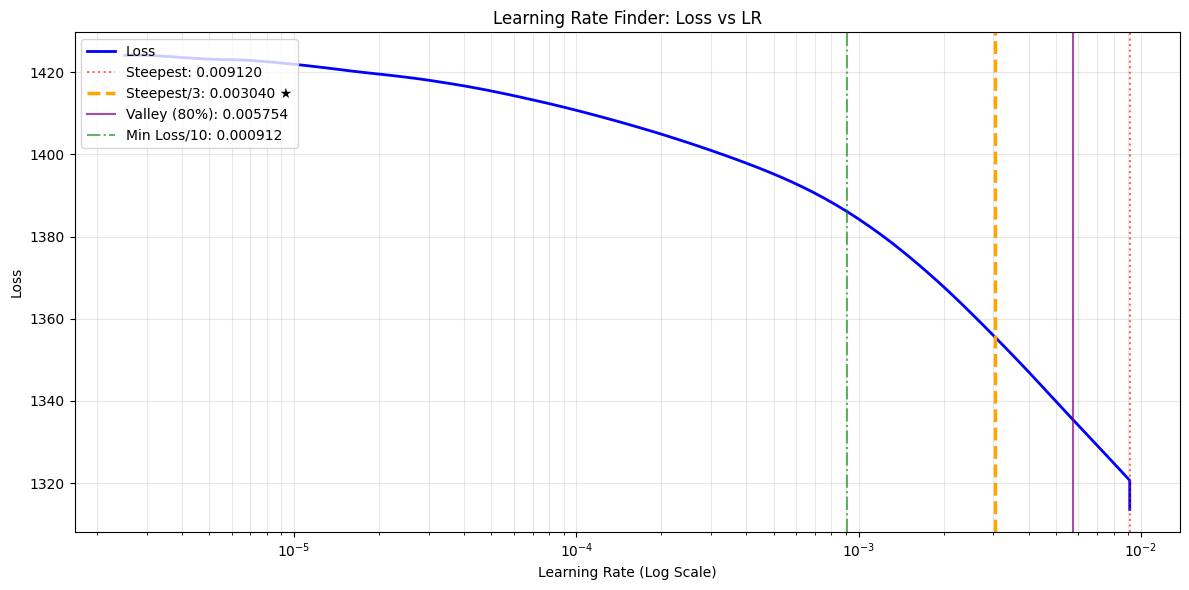

             LR FINDER RESULTS
  🔴 Steepest Gradient : 0.009120  (aggressive)
  🟠 Steepest / 3      : 0.003040  (balanced) ★ DEFAULT
  🟣 Valley (80%)      : 0.005754  (robust)
  🟢 Min Loss / 10     : 0.000912  (conservative)
  Selected Method: 'recommended' → LR = 0.003040

Optimal learning rate: 0.003040


In [11]:
# LRFinder: Uses dynamically determined BATCH_SIZE via data generator
NUM_LR_STEPS = 100
print(f"Running LRFinder with BATCH_SIZE={BATCH_SIZE} for {NUM_LR_STEPS} steps...")

# For VAE with custom Lambda layers, save weights instead of cloning
initial_weights = vae.model.get_weights()

# VAE reconstruction loss (using keras.ops for Keras 3.x compatibility)
def vae_r_loss(y_true, y_pred):
    """Reconstruction loss for VAE."""
    return R_LOSS_FACTOR * ops.mean(ops.square(y_true - y_pred), axis=[1, 2, 3])

vae.model.compile(loss=vae_r_loss, optimizer=Adam(learning_rate=1e-6))

# Run LRFinder with data_flow to use the global BATCH_SIZE
lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-2, steps=NUM_LR_STEPS)
vae.model.fit(
    data_flow,
    epochs=4,
    steps_per_epoch=NUM_LR_STEPS,
    callbacks=[lr_finder],
    verbose=0
)

# Plot and get optimal LR
lr_finder.plot_loss()
optimal_lr = lr_finder.get_optimal_lr()
print(f"\nOptimal learning rate: {optimal_lr:.6f}")

# Update W&B config
wandb.config.update({"learning_rate": optimal_lr})

# Restore original weights after LRFinder
vae.model.set_weights(initial_weights)
tf.keras.backend.clear_session()

## Training

Train the VAE with the optimal learning rate and full callback stack.

In [ ]:
# ═══════════════════════════════════════════════════════════════════
# TRAINING CALLBACKS CONFIGURATION
# ═══════════════════════════════════════════════════════════════════
# - WandbMetricsLogger: Logs all metrics to Weights & Biases
# - get_lr_scheduler: Reduces LR when loss plateaus (patience=5 epochs)
# - get_early_stopping: Stops training when loss stops improving
#   * patience=20: Wait 20 epochs without improvement before stopping
#   * min_delta=0.5: Minimum improvement required to count as progress.
#     NOTE: For VAE losses typically in the 200-300 range, a min_delta
#     of 1e-4 is effectively zero (too small to detect meaningful change).
#     Using 0.5 (~0.2% of loss) ensures only significant improvements
#     are recognized, preventing premature early stopping.
# - LRLogger: Logs current learning rate each epoch for debugging
# ═══════════════════════════════════════════════════════════════════

# Compile with optimal LR
vae.compile(optimal_lr, R_LOSS_FACTOR)

# Define extra callbacks for W&B tracking and training optimization
extra_callbacks = [
    WandbMetricsLogger(),
    get_lr_scheduler(monitor='loss', patience=10, factor=0.5),
    get_early_stopping(monitor='loss', patience=20, min_delta=0.5),
    LRLogger(),
]

print(f"Training with optimal LR: {optimal_lr:.6f}")
print(f"Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {NUM_IMAGES // BATCH_SIZE}")

Training with optimal LR: 0.003040
Epochs: 150, Batch size: 288
Steps per epoch: 703


In [13]:
# Train the model
vae.train_with_generator(
    data_flow,
    epochs=EPOCHS,
    steps_per_epoch=NUM_IMAGES // BATCH_SIZE,
    run_folder=RUN_FOLDER,
    print_every_n_batches=PRINT_EVERY_N_BATCHES,
    initial_epoch=INITIAL_EPOCH,
    extra_callbacks=extra_callbacks,
)

Epoch 1/150
150/703 ━━━━━━━━━━━━━━━━━━━━ 7:38 829ms/step - loss: 835.6371 - vae_r_loss: 635.4183

2026-01-04 16:39:42.351060: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 16:39:42.464211: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 16:39:42.703078: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 16:39:42.869497: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-04 16:39:42.979873: E external/local_xla/xla/service

703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - loss: 504.3947 - vae_r_loss: 388.2237
Epoch 1: saving model to ../run/vae/0001_faces/weights/weights-001-341.66.weights.h5

Epoch 1: finished saving model to ../run/vae/0001_faces/weights/weights-001-341.66.weights.h5

Epoch 1: saving model to ../run/vae/0001_faces/weights/weights.weights.h5

Epoch 1: finished saving model to ../run/vae/0001_faces/weights/weights.weights.h5
 Epoch 1: Learning Rate is 3.04e-03
703/703 ━━━━━━━━━━━━━━━━━━━━ 574s 779ms/step - loss: 341.6560 - vae_r_loss: 263.6105 - learning_rate: 0.0030
Epoch 2/150
  1/703 ━━━━━━━━━━━━━━━━━━━━ 5:42 489ms/step - loss: 237.4341 - vae_r_loss: 177.8521
Epoch 2: saving model to ../run/vae/0001_faces/weights/weights-002-237.43.weights.h5


/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: finished saving model to ../run/vae/0001_faces/weights/weights-002-237.43.weights.h5

Epoch 2: saving model to ../run/vae/0001_faces/weights/weights.weights.h5

Epoch 2: finished saving model to ../run/vae/0001_faces/weights/weights.weights.h5
 Epoch 2: Learning Rate is 3.04e-03
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 237.4341 - vae_r_loss: 177.8521 - learning_rate: 0.0030
Epoch 3/150
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - loss: 241.2039 - vae_r_loss: 183.2920
Epoch 3: saving model to ../run/vae/0001_faces/weights/weights-003-237.94.weights.h5

Epoch 3: finished saving model to ../run/vae/0001_faces/weights/weights-003-237.94.weights.h5

Epoch 3: saving model to ../run/vae/0001_faces/weights/weights.weights.h5

Epoch 3: finished saving model to ../run/vae/0001_faces/weights/weights.weights.h5
 Epoch 3: Learning Rate is 3.04e-03
703/703 ━━━━━━━━━━━━━━━━━━━━ 373s 528ms/step - loss: 237.9371 - vae_r_loss: 180.2603 - learning_rate: 0.0030
Epoch 4/150
  1/703 ━━━━━━

## Post-Training Visualization

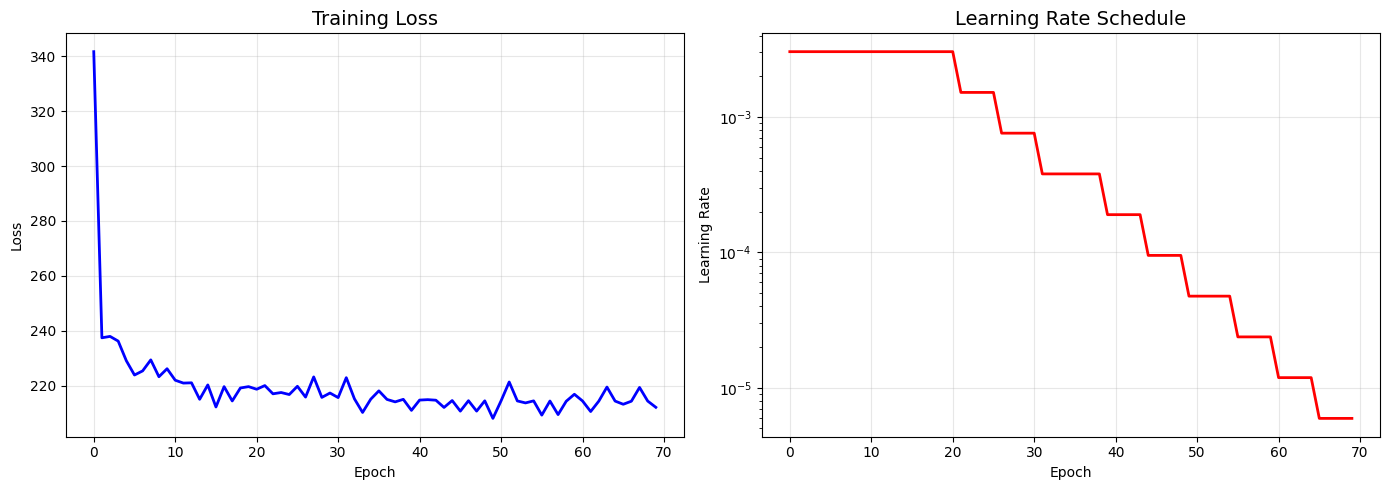


Initial Loss: 341.6560
Final Loss: 212.1050

Training history saved to: ../run/vae/0001_faces/viz/training_history.png


In [14]:
# ═══════════════════════════════════════════════════════════════════
# POST-TRAINING VISUALIZATION
# ═══════════════════════════════════════════════════════════════════
history = vae.model.history.history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['loss'], 'b-', linewidth=2)
axes[0].set_title('Training Loss', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# Learning rate plot (log scale)
if 'learning_rate' in history:
    axes[1].semilogy(history['learning_rate'], 'r-', linewidth=2)
    axes[1].set_title('Learning Rate Schedule', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Learning Rate')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'LR history not available', 
                 ha='center', va='center', fontsize=12)
    axes[1].set_title('Learning Rate Schedule', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(RUN_FOLDER, 'viz/training_history.png'), dpi=150)
plt.show()

print(f"\nInitial Loss: {history['loss'][0]:.4f}")
print(f"Final Loss: {history['loss'][-1]:.4f}")
print(f"\nTraining history saved to: {RUN_FOLDER}/viz/training_history.png")

## Cleanup

In [15]:
wandb.finish()
print("W&B run finished. Check your dashboard at https://wandb.ai")

batch_finder/model_memory_mb,▁
batch_finder/model_params,▁
batch_finder/optimal_batch_size,▁
epoch/epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,██████████████▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
epoch/vae_r_loss,▇██▅▆▄▄▂▁▃▃▃▃▃▃▃▂▄▂▃▂▁▂▃▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▂
learning_rate,█████████████▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_finder/input_shape,"(128, 128, 3)"
batch_finder/model_memory_mb,50.93852
batch_finder/model_params,3338307


W&B run finished. Check your dashboard at https://wandb.ai


# Cleanup: Restart Kernel to Release GPU Memory

In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# CLEANUP: Restart kernel to fully release GPU memory
# ═══════════════════════════════════════════════════════════════════════════════
# TensorFlow/CUDA does not release GPU memory within a running Python process.
# Restarting the kernel is the only guaranteed way to free all GPU resources.
# Run this cell only after all work is complete and saved.

# import IPython
# print("Restarting kernel to release GPU memory...")
# IPython.Application.instance().kernel.do_shutdown(restart=True)